In [1]:
from MyViT import ViT
import torch

### **无representation_size，无distilled**

In [2]:
vit_base = ViT(
    img_size=224,
    patchsize=16,
    in_channels=3,
    num_classes=1000,
    embed_dim=768,
    depth=12,
    num_heads=12,
    mlp_ratio=4,
    qkv_bias=True,
    representation_size=None,  
    distilled=False,          
    dropout=0.1
)

x = torch.randn(1, 3, 224, 224)  # 示例输入
inputs = torch.cat((x,x), dim=0)  # 模拟batch size为2的输入
vit_base.eval()  
output = vit_base(inputs)
print(output.shape)  # torch.Size([1, 1000]) - 直接从cls_token分类

torch.Size([2, 1000])


### **representation_size但不带distilled的ViT**

In [3]:
# 在分类前添加额外投影头的ViT
vit_with_rep = ViT(
    img_size=224,
    patchsize=16,
    in_channels=3,
    num_classes=1000,
    embed_dim=768,
    depth=12,
    num_heads=12,
    mlp_ratio=4,
    qkv_bias=True,
    representation_size=512,  # 添加投影头
    distilled=False,          # 无蒸馏token
    dropout=0.1
)

# 前向传播：
x = torch.randn(1, 3, 224, 224)
output = vit_with_rep(x)
print(output.shape)  # torch.Size([1, 1000]) 
# 内部会经过768->512的投影再进行最终分类

torch.Size([1, 1000])


### **带distilled但不带representation_size的ViT**

In [4]:
# 带蒸馏token的ViT(类似DeiT)
vit_distilled = ViT(
    img_size=224,
    patchsize=16,
    in_channels=3,
    num_classes=1000,
    embed_dim=768,
    depth=12,
    num_heads=12,
    mlp_ratio=4,
    qkv_bias=True,
    representation_size=None,  # 无投影头
    distilled=True,           # 使用蒸馏token
    dropout=0.1
)

# 前向传播：
x = torch.randn(1, 3, 224, 224)
output = vit_distilled(x)
# 训练模式下返回(cls_logits, dist_logits)元组
vit_distilled.train()
train_output = vit_distilled(x)
print(len(train_output))  # 2 - cls和dist两个输出
print(train_output[0].shape, train_output[1].shape)  # torch.Size([1, 1000]), torch.Size([1, 1000])

# 评估模式下返回两者的平均值
vit_distilled.eval()
eval_output = vit_distilled(x)
print(eval_output.shape)  # torch.Size([1, 1000]) - 两个头的平均值

2
torch.Size([1, 1000]) torch.Size([1, 1000])
torch.Size([1, 1000])


### **同时带representation_size和distilled的ViT**

In [5]:
# 同时带投影头和蒸馏token的ViT
vit_full = ViT(
    img_size=224,
    patchsize=16,
    in_channels=3,
    num_classes=1000,
    embed_dim=768,
    depth=12,
    num_heads=12,
    mlp_ratio=4,
    qkv_bias=True,
    representation_size=512,  # 添加投影头
    distilled=True,          # 使用蒸馏token
    dropout=0.1
)

# 前向传播行为：
x = torch.randn(1, 3, 224, 224)
vit_full.train()
train_output = vit_full(x)
print(len(train_output))  # 2 - cls和dist两个输出
print(train_output[0].shape, train_output[1].shape)  # 都是torch.Size([1, 1000])

vit_full.eval()
eval_output = vit_full(x)
print(eval_output.shape)  # torch.Size([1, 1000]) - 平均值

2
torch.Size([1, 1000]) torch.Size([1, 1000])
torch.Size([1, 1000])


### **模型训练**

In [6]:
from ViTTrainer import MyTrainer

In [7]:
trainer = MyTrainer(data_path='flower_photos',weights='',freeze_layers=False)

In [8]:
# trainer.train()

In [9]:
import os
import json 
import torch 
from PIL import Image 
from torchvision import transforms 
import matplotlib.pyplot as plt 
from MyViT import *
class PipelineForPhotoClassification:
    def __init__(self,weight:str,class_indices:str):
        self.weight = weight 
        self.class_indices = class_indices 


    def __call__(self,img_path:str):

        device = torch.device('cuda:0')

        data_transform = transforms.Compose([transforms.Resize(256),transforms.CenterCrop(224),transforms.ToTensor(),transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])])
        assert os.path.exists(img_path), f'file: {img_path} does not exist.'
        img = Image.open(img_path)
        plt.imshow(img)
        img = data_transform(img)
        img = img.unsqueeze(0)

        json_path = self.class_indices 
        assert os.path.exists(json_path), f'file: {json_path} does not exist.'

        with open(json_path, 'r') as f: 
            class_indict = json.load(f)

        model = ViT(img_size=224,patchsize=16,embed_dim=768,depth=12,num_heads=12,representation_size=None,num_classes=5).to(device)
        model_weight_path = self.weight 
        model.load_state_dict(torch.load(model_weight_path,map_location=device))
        model.eval() 

        with torch.no_grad(): 
            output = torch.squeeze(model(img.to(device))).cpu()
            predict = torch.softmax(output,dim=0)
            predict_cls = torch.argmax(predict).numpy() 

        predict_res = f'class: {class_indict[str(predict_cls)]}  prob: {predict[predict_cls].numpy():.3}'

        print(predict_res)
        for i in range(len(predict)):
            print(f'class:{class_indict[str(i)]:10},  prob:{predict[i].numpy():.3}')

        plt.show()


In [10]:
pipe = PipelineForPhotoClassification(weight='weights/model-9.pth',class_indices='cls_indices.json')

class: daisy  prob: 0.93
class:daisy     ,  prob:0.93
class:dandelion ,  prob:0.0317
class:roses     ,  prob:0.0145
class:sunflowers,  prob:0.00429
class:tulips    ,  prob:0.0192


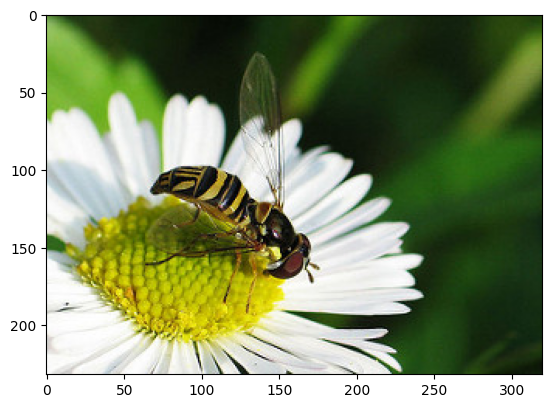

In [11]:
pipe('predict_photo.jpg')